<a href="https://colab.research.google.com/github/jamessutton600613-png/GC/blob/main/Untitled65.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

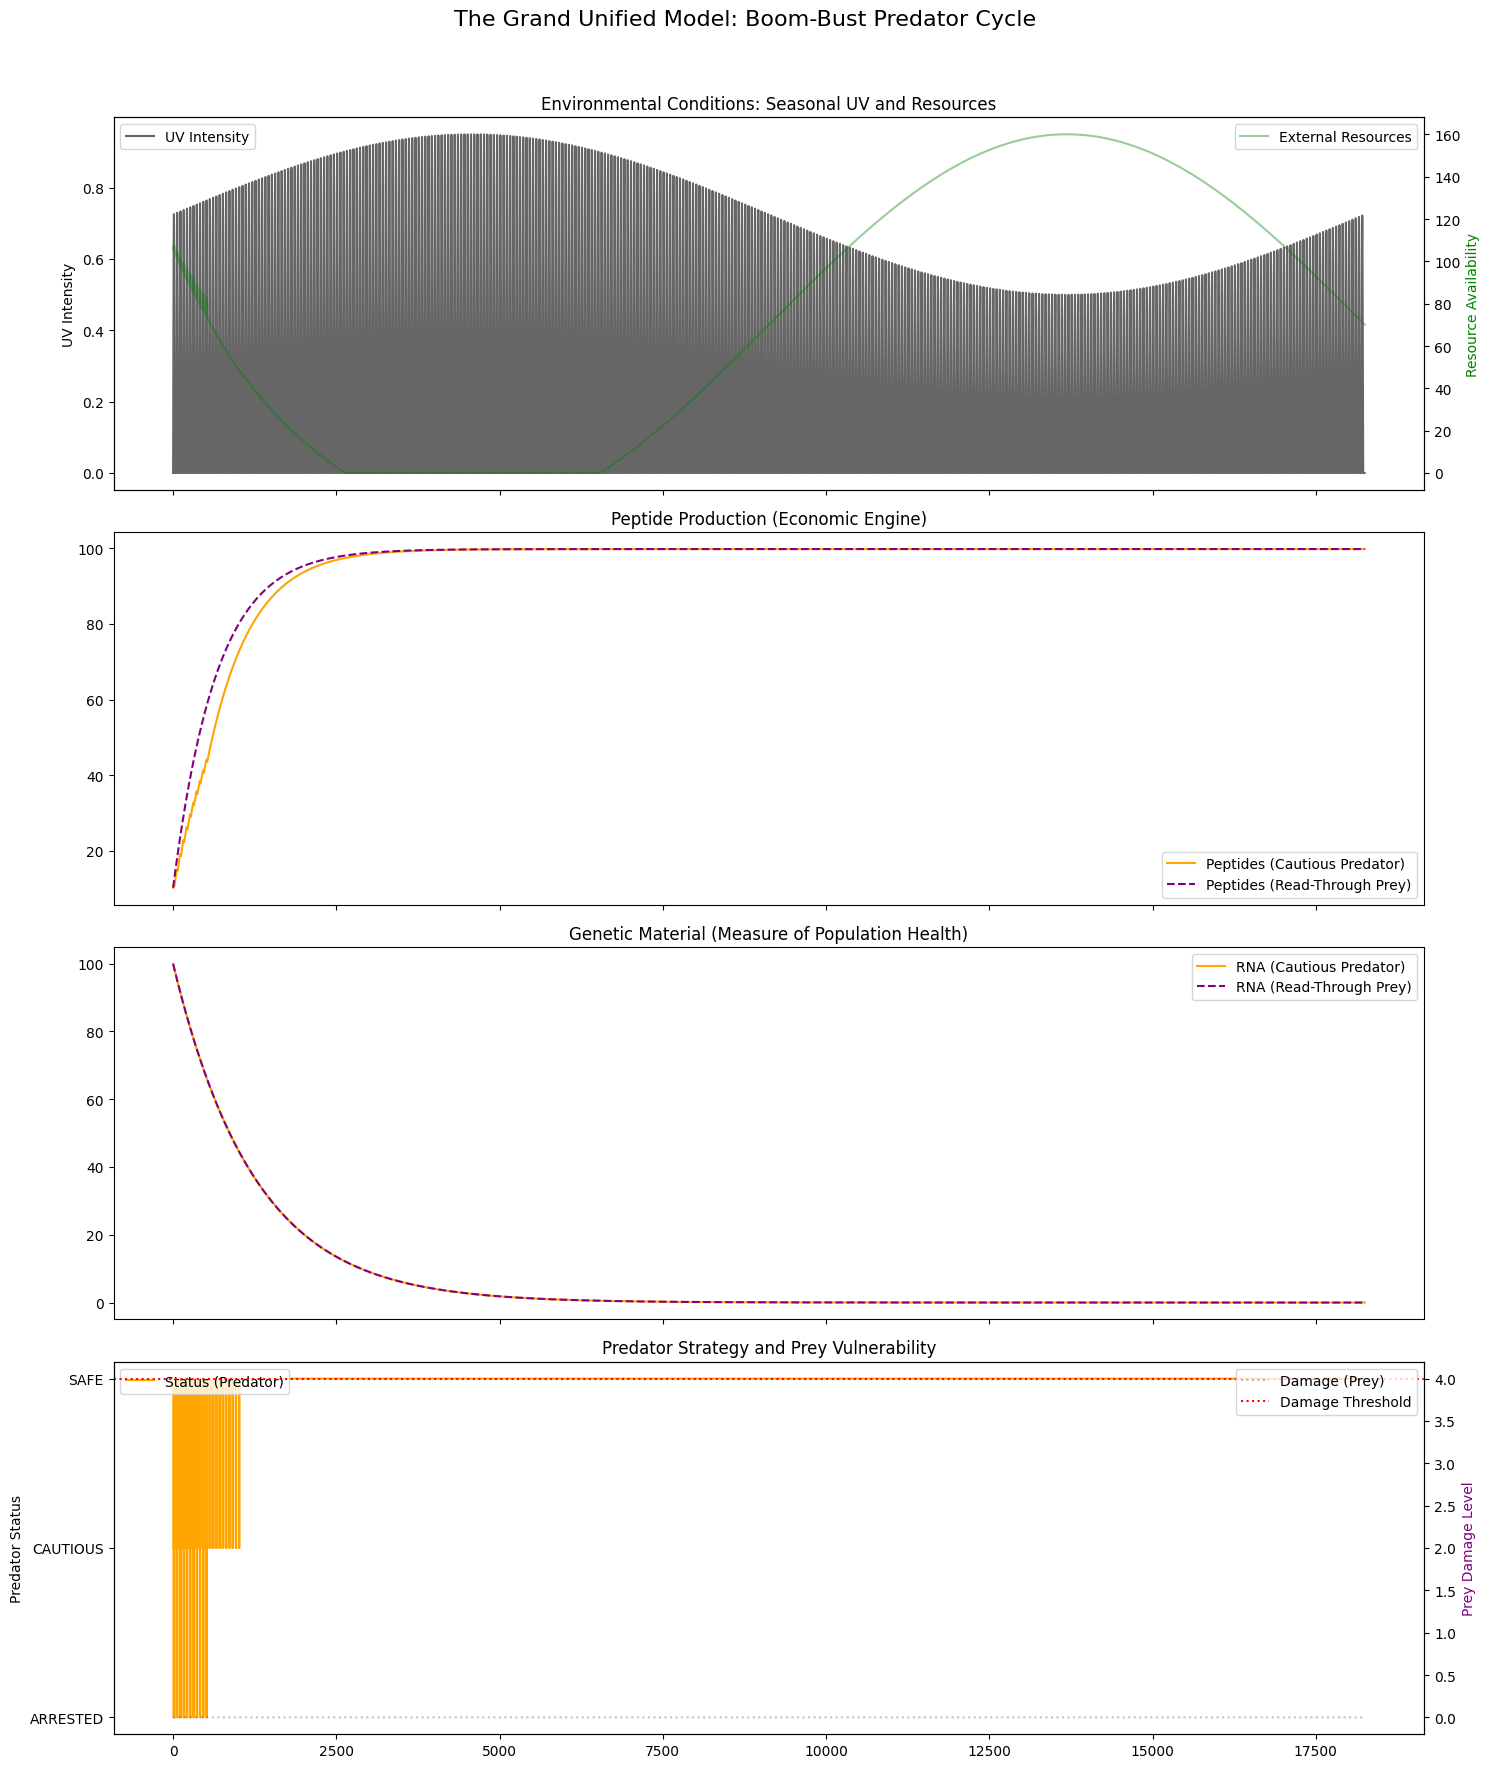

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- 1. Environment with Seasonal Resources ---
class Environment:
    def __init__(self, total_sim_steps, days_per_cycle=50):
        self.total_sim_steps, self.days_per_cycle, self.time = total_sim_steps, days_per_cycle, 0
        num_years = total_sim_steps / (365 * days_per_cycle)

        # UV Cycle
        daily_uv_cycle = np.sin(np.linspace(0, 2 * np.pi, days_per_cycle)); daily_uv_cycle[daily_uv_cycle < 0] = 0
        seasonal_uv_mod = 0.225 * np.sin(np.linspace(0, 2 * np.pi * num_years, total_sim_steps)) + 0.725
        self.uv_intensity = np.array([daily_uv_cycle[i % days_per_cycle] * seasonal_uv_mod[i] for i in range(total_sim_steps)])

        # Seasonal Resource Cycle: Rich winter, lean summer
        seasonal_resource_mod = -0.45 * np.sin(np.linspace(0, 2 * np.pi * num_years, total_sim_steps)) + 0.55
        self.external_trp_tyr_cys_pool = 200 * seasonal_resource_mod

    def get_current_uv(self):
        return self.uv_intensity[self.time] if self.time < self.total_sim_steps else 0.0

    def get_current_resources(self):
        return self.external_trp_tyr_cys_pool[self.time] if self.time < self.total_sim_steps else 0.0

    def step(self):
        self.time += 1

# --- 2. RNA_Peptide_Complex with Foraging and Predation ---
class RNA_Peptide_Complex:
    def __init__(self, env, strategy='cautious'):
        self.env, self.strategy = env, strategy
        self.rna_pool, self.atp_pool = 100.0, 50.0
        self.mcyw_peptide_pool, self.other_peptide_pool = 10.0, 5.0
        self.internal_ntp_stock, self.internal_aa_stock, self.internal_trp_tyr_cys_stock = 100.0, 100.0, 50.0
        self.rna_damage_level, self.protein_synthesis_active = 0.0, True
        self.uv_safety_status, self.premature_stop_signal = "SAFE", 0.0
        self.mcyw_synthesis_bias = 0.75 if strategy != 'generic' else 0.0

        # --- Tuned for Boom-Bust Cycle ---
        self.uv_damage_rate_per_uv = 0.55
        self.repair_rate = 0.5
        self.trp_tyr_cys_for_repair_needed = 0.10
        self.scavenge_efficiency = 0.6
        self.foraging_efficiency = 0.2
        self.premature_stop_signal_threshold = 0.20
        self.damage_tolerance_threshold = 4.0

        # Correctly defined degradation rates
        self.rna_degradation_rate=0.0008
        self.peptide_degradation_rate=0.0015
        self.atp_degradation_rate=0.003

        self.atp_generation_rate_per_mcyw_uv=0.15
        self.repair_atp_cost=0.005
        self.protein_synthesis_rate=0.20
        self.protein_synthesis_ntp_cost=0.1
        self.protein_synthesis_aa_cost=0.1
        self.protein_synthesis_atp_cost=0.02
        self.foraging_atp_cost = 0.01


    def _apply_uv_damage(self):
        uv = self.env.get_current_uv()
        if uv > 0:
            protection = self.mcyw_peptide_pool * 0.01
            effective_uv = uv * max(0, 1 - protection)
            damage_increase = effective_uv * self.uv_damage_rate_per_uv
            self.rna_damage_level += damage_increase
            self.premature_stop_signal = damage_increase * 1.5
        else:
            self.premature_stop_signal = 0

    def _manage_state(self):
        stop_signal = self.premature_stop_signal
        if self.strategy == 'readthrough': stop_signal = 0
        norm_dmg = min(1., self.rna_damage_level / self.damage_tolerance_threshold)
        danger = (norm_dmg * 0.5) + (stop_signal * 0.5)
        if danger >= self.premature_stop_signal_threshold:
            self.protein_synthesis_active = False; self.uv_safety_status = "ARRESTED"
        elif danger < self.premature_stop_signal_threshold * 0.5:
            self.protein_synthesis_active = True; self.uv_safety_status = "SAFE"
        else:
            self.uv_safety_status = "CAUTIOUS"

    def _forage(self):
        if self.protein_synthesis_active and self.mcyw_peptide_pool > 0 and self.atp_pool > self.foraging_atp_cost:
            foraged_amount = self.mcyw_peptide_pool * self.foraging_efficiency
            available_resources = self.env.get_current_resources()
            taken_resources = min(foraged_amount, available_resources)
            if available_resources > 0:
                self.env.external_trp_tyr_cys_pool[self.env.time] -= taken_resources
                self.internal_trp_tyr_cys_stock += taken_resources
                self.atp_pool -= self.foraging_atp_cost

    def _scavenge(self, prey):
        if self.env.get_current_uv() > 0.05 or prey.rna_damage_level < prey.damage_tolerance_threshold * 0.8: return
        scavenged_peptides = prey.mcyw_peptide_pool * self.scavenge_efficiency * 0.1
        prey.mcyw_peptide_pool = max(0, prey.mcyw_peptide_pool - scavenged_peptides)
        self.internal_trp_tyr_cys_stock += scavenged_peptides * (self.protein_synthesis_aa_cost * self.mcyw_synthesis_bias)

    def _synthesize_protein(self):
        if not self.protein_synthesis_active: return
        units=self.protein_synthesis_rate
        cost_aas = units * self.protein_synthesis_aa_cost
        if not (self.internal_trp_tyr_cys_stock >= cost_aas): return

        self.internal_trp_tyr_cys_stock -= cost_aas
        self.mcyw_peptide_pool += units * self.mcyw_synthesis_bias
        self.other_peptide_pool += units * (1 - self.mcyw_synthesis_bias)
        self.atp_pool -= units * self.protein_synthesis_atp_cost

    def _synthesize_atp(self):
        if self.env.get_current_uv()>0 and self.mcyw_peptide_pool>0: self.atp_pool+=self.atp_generation_rate_per_mcyw_uv*self.mcyw_peptide_pool*self.env.get_current_uv()

    def _repair_rna_dna(self):
        if self.rna_damage_level > 0 and self.atp_pool>=self.repair_atp_cost and self.internal_trp_tyr_cys_stock>=self.trp_tyr_cys_for_repair_needed:
            self.atp_pool-=self.repair_atp_cost
            self.internal_trp_tyr_cys_stock-=self.trp_tyr_cys_for_repair_needed
            self.rna_damage_level-=min(self.rna_damage_level,self.repair_rate)

    def _degrade(self):
        # --- CORRECTED DEGRADATION LOGIC ---
        self.rna_pool *= (1 - self.rna_degradation_rate)
        self.mcyw_peptide_pool *= (1 - self.peptide_degradation_rate)
        self.other_peptide_pool *= (1 - self.peptide_degradation_rate)
        self.atp_pool *= (1 - self.atp_degradation_rate)

    def step(self, prey=None):
        self._apply_uv_damage()
        self._manage_state()
        self._synthesize_atp()
        self._repair_rna_dna()
        self._forage()
        if prey and self.strategy == 'cautious': self._scavenge(prey)
        self._synthesize_protein()
        self._degrade()

def run_and_plot():
    SIMULATION_DAYS = 365
    TOTAL_STEPS = SIMULATION_DAYS * 50

    env=Environment(TOTAL_STEPS)
    cautious = RNA_Peptide_Complex(env, strategy='cautious')
    readthrough = RNA_Peptide_Complex(env, strategy='readthrough')

    data = []
    for i in range(TOTAL_STEPS):
        cautious.step(prey=readthrough)
        readthrough.step()
        data.append({
            'time': env.time, 'uv': env.get_current_uv(), 'resources': env.get_current_resources(),
            'rna_cautious': cautious.rna_pool, 'rna_readthrough': readthrough.rna_pool,
            'peptides_cautious': cautious.mcyw_peptide_pool, 'peptides_readthrough': readthrough.mcyw_peptide_pool,
            'damage_cautious': cautious.rna_damage_level, 'damage_readthrough': readthrough.rna_damage_level,
            'status_cautious': cautious.uv_safety_status, 'status_readthrough': readthrough.uv_safety_status
        })
        env.step()

    df = pd.DataFrame(data)

    fig, axs = plt.subplots(4, 1, figsize=(15, 18), sharex=True)
    fig.suptitle('The Grand Unified Model: Boom-Bust Predator Cycle', fontsize=16)
    colors = {'cautious': 'orange', 'readthrough': 'purple'}

    # Plot 1: Environment
    ax0_twin = axs[0].twinx()
    axs[0].plot(df['time'], df['uv'], color='black', alpha=0.6, label='UV Intensity')
    ax0_twin.plot(df['time'], df['resources'], color='green', alpha=0.4, label='External Resources')
    axs[0].set_ylabel('UV Intensity'); ax0_twin.set_ylabel('Resource Availability', color='green')
    axs[0].set_title('Environmental Conditions: Seasonal UV and Resources'); axs[0].legend(loc='upper left'); ax0_twin.legend(loc='upper right')

    # Plot 2: Peptides
    axs[1].plot(df['time'], df['peptides_cautious'], color=colors['cautious'], label='Peptides (Cautious Predator)')
    axs[1].plot(df['time'], df['peptides_readthrough'], color=colors['readthrough'], linestyle='--', label='Peptides (Read-Through Prey)')
    axs[1].set_title('Peptide Production (Economic Engine)'); axs[1].legend()

    # Plot 3: Genetic Material
    axs[2].plot(df['time'], df['rna_cautious'], color=colors['cautious'], label='RNA (Cautious Predator)')
    axs[2].plot(df['time'], df['rna_readthrough'], color=colors['readthrough'], linestyle='--', label='RNA (Read-Through Prey)')
    axs[2].set_title('Genetic Material (Measure of Population Health)'); axs[2].legend()

    # Plot 4: Safety Strategy & Damage
    ax3_twin = axs[3].twinx()
    status_map={"SAFE":1,"CAUTIOUS":0.5,"ARRESTED":0}
    ax3_twin.plot(df['time'], df['damage_readthrough'], color=colors['readthrough'], alpha=0.3, linestyle=':', label='Damage (Prey)')
    ax3_twin.axhline(y=cautious.damage_tolerance_threshold, color='red', linestyle=':', label='Damage Threshold')
    axs[3].plot(df['time'], df['status_cautious'].map(status_map), label='Status (Predator)', color=colors['cautious'], drawstyle='steps-post')
    axs[3].set_yticks([0,0.5,1]); axs[3].set_yticklabels(["ARRESTED","CAUTIOUS","SAFE"])
    axs[3].set_ylabel('Predator Status'); ax3_twin.set_ylabel('Prey Damage Level', color='purple')
    axs[3].set_title('Predator Strategy and Prey Vulnerability'); axs[3].legend(loc='upper left'); ax3_twin.legend(loc='upper right')

    plt.tight_layout(rect=[0, 0, 1, 0.96]); plt.show()

if __name__ == "__main__":
    run_and_plot()
